In [1]:
import sys
!{sys.executable} -m pip install -r requirements_backtest.txt

Looking in links: https://files.pythonhosted.org/


In [2]:
import scipy
import patsy
import pickle

import numpy as np
import pandas as pd

import scipy.sparse
import matplotlib.pyplot as plt

from statistics import median
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols
from tqdm import tqdm

In [3]:
barra_dir = './data/backtest/'

data = {}
for year in [2004]:
    fil = barra_dir + "pandas-frames." + str(year) + ".pickle"
    data.update(pickle.load( open( fil, "rb" ) ))
    
covariance = {}
for year in [2004]:
    fil = barra_dir + "covariance." + str(year) + ".pickle"
    covariance.update(pickle.load( open(fil, "rb" ) ))
    
daily_return = {}
for year in [2004, 2005]:
    fil = barra_dir + "price." + str(year) + ".pickle"
    daily_return.update(pickle.load( open(fil, "rb" ) ))

## Factors
Note that the data fields that start with the prefix U-S-F-A-S-T are factor exposures. Use some of these as alpha factors, and the rest as risk factors. This is becauase, for the time periods of back-testing, some of these factors were able to produce better than average returns. 

According to the documentation by Barra, these are the barra factor definitions. The industry factors will be used as risk factors, whereas some of style factors can be considered as alpha factors. Any factors not used as alpha factors can be included in the risk factors category.

#### Style factors
* beta: Describes market risk that cannot be explained by the Country factor. The Beta factor is typically the most important style factor. We calculate Beta by time-series regression of stock excess returns against the market return.
* 1 day reversal
* dividend yield: Describes differences in stock returns attributable to stock's historical and predicted dividend-to-price ratios.
* downside risk (maximum drawdown)
* earnings quality:  Describes stock return differences due to the accrual components of earnings.
* earnings yield: Describes return differences based on a company’s earnings relative to its price. Earnings Yield is considered by many investors to be a strong value signal. The most important descriptor in this factor is the analyst-predicted 12-month earnings-to-price ratio.
* growth: Differentiates stocks based on their prospects for sales or earnings growth. The most important descriptor in this factor is the analyst predicted long-term earnings growth. Other descriptors include sales and earnings growth over the previous five years.
* leverage: Describes return differences between high and low-leverage stocks. The descriptors within this style factor include market leverage, book leverage, and debt-to-assets ratio.
* liquidity: Describes return differences due to relative trading activity. The descriptors for this factor are based on the fraction of total shares outstanding that trade over a recent window.
* long-term reversal: Describes common variation in returns related to a long-term (five years ex. recent thirteen months) stock price behavior.
* management quality
* Mid capitalization: Describes non-linearity in the payoff to the Size factor across the market-cap spectrum. This factor is based on a single raw descriptor: the cube of the Size exposure. However, because this raw descriptor is highly collinear with the Size factor, it is orthogonalized with respect to Size. This procedure does not affect the fit of the model, but does mitigate the confounding effects of collinearity, while preserving an intuitive meaning for the Size factor. As described by Menchero (2010), the Mid Capitalization factor roughly captures the risk of a “barbell portfolio” that is long mid-cap stocks and short small-cap and large-cap stocks.
* Momentum – Differentiates stocks based on their performance over the trailing 12 months. When computing Momentum exposures, we exclude the most recent returns in order to avoid the effects of short-term reversal. The Momentum factor is often the second strongest factor in the model, although sometimes it may surpass Beta in importance.
* Profitability – Combines profitability measures that characterize efficiency of a firm's operations and total activities.
* Residual Volatility – Measures the idiosyncratic volatility anomaly. It has three descriptors: (a) the volatility of daily excess returns, (b) the volatility of daily residual returns, and (c) the cumulative range of the stock over the last 12 months. Since these descriptors tend to be highly collinear with the Beta factor, the Residual Volatility factor is orthogonalized with respect to the Beta and Size factors.
* seasonality
* sentiment
* Size – Represents a strong source of equity return covariance, and captures return differences between large-cap and small-cap stocks. We measure Size by the log of market capitalization.
* Short term reversal
* Value
* Prospect -- is a function of skewness and maximum drawdown.
* Management Quality -- is a function of the following: 
    * Asset Growth: Annual reported company assets are regressed against time over the past five fiscal years. The slope coefficient is then divided by the average annual assets to obtain the asset growth.
    * Issuance Growth Annual reported company number of shares outstanding regressed against time over the past five fiscal years. The slope coefficient is then divided by the average annual number of shares outstanding.
    * Capital Expenditure Growth: Annual reported company capital expenditures are regressed against time over the past five fiscal years. The slope coefficient is then divided by the average annual capital expenditures to obtain the capital expenditures growth.
    * Capital Expenditure: The most recent capital expenditures are scaled by the average of capital expenditures over the last five fiscal years.



#### Industry Factors
* aerospace and defense
* airlines
* aluminum and steel
* apparel
* Automotive
* banks
* beta (market)
* beverage and tobacco
* biotech & life science
* building products
* chemicals
* construction & engineering
* construction & machinery
* construction materials
* commercial equipment
* computer & electronics
* commercial services
* industrial conglomerates
* containers (forest, paper, & packaging)
* distributors
* diversified financials
* electrical equipment
* electrical utility
* food & household products & personal
* food & staples retailing
* gas & multi-utilities
* healthcare equipment and services
* health services
* home building
* household durables
* industry machinery
* non-life insurance
* leisure products
* leisure services
* life insurance
* managed healthcare
* multi-utilities
* oil & gas conversion
* oil & gas drilling
* oil & gas equipment
* oil and gas export
* paper
* pharmaceuticals
* precious metals
* personal products
* real estate
* restaurants
* road & rail
* semiconductors
* semiconductors equipment
* software
* telecommunications
* transportation
* wireless
* SPTY\* and SPLTY\* are various industries

In [4]:
data['20040102'].columns

Index(['Barrid', 'USFASTD_1DREVRSL', 'USFASTD_AERODEF', 'USFASTD_AIRLINES',
       'USFASTD_ALUMSTEL', 'USFASTD_APPAREL', 'USFASTD_AUTO', 'USFASTD_BANKS',
       'USFASTD_BETA', 'USFASTD_BEVTOB', 'USFASTD_BIOLIFE', 'USFASTD_BLDGPROD',
       'USFASTD_CHEM', 'USFASTD_CNSTENG', 'USFASTD_CNSTMACH',
       'USFASTD_CNSTMATL', 'USFASTD_COMMEQP', 'USFASTD_COMPELEC',
       'USFASTD_COMSVCS', 'USFASTD_CONGLOM', 'USFASTD_CONTAINR',
       'USFASTD_DISTRIB', 'USFASTD_DIVFIN', 'USFASTD_DIVYILD',
       'USFASTD_DWNRISK', 'USFASTD_EARNQLTY', 'USFASTD_EARNYILD',
       'USFASTD_ELECEQP', 'USFASTD_ELECUTIL', 'USFASTD_FOODPROD',
       'USFASTD_FOODRET', 'USFASTD_GASUTIL', 'USFASTD_GROWTH',
       'USFASTD_HLTHEQP', 'USFASTD_HLTHSVCS', 'USFASTD_HOMEBLDG',
       'USFASTD_HOUSEDUR', 'USFASTD_INDMACH', 'USFASTD_INDMOM',
       'USFASTD_INSURNCE', 'USFASTD_INTERNET', 'USFASTD_LEISPROD',
       'USFASTD_LEISSVCS', 'USFASTD_LEVERAGE', 'USFASTD_LIFEINS',
       'USFASTD_LIQUIDTY', 'USFASTD_LTREVRSL', 'USF

In [5]:
print("len(data)        : {}, min(data.keys())        : {}, max(data.keys())        : {}".format(len(data), min(data.keys()), max(data.keys())))
print("len(daily_return): {}, min(daily_return.keys()): {}, max(daily_return.keys()): {}".format(len(daily_return), min(daily_return.keys()), max(daily_return.keys())))
print("len(covariance)  : {}, min(covariance.keys())  : {}, max(covariance.keys())  : {}".format(len(covariance), min(covariance.keys()), max(covariance.keys())))

len(data)        : 252, min(data.keys())        : 20040102, max(data.keys())        : 20041231
len(daily_return): 504, min(daily_return.keys()): 20040102, max(daily_return.keys()): 20051230
len(covariance)  : 252, min(covariance.keys())  : 20040102, max(covariance.keys())  : 20041231


In [6]:
pd.set_option('display.max_rows', 8)
pd.set_option('display.max_columns', 8)
data['20040102']

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,...,SpecRisk,HistBeta,PredBeta,DataDate
0,USA0001,-0.032,0.000,0.0,...,9.014505,-0.000189,0.156387,20040102
1,USA0011,-0.059,0.000,0.0,...,11.726327,0.000013,0.147900,20040102
2,USA0031,0.457,0.000,0.0,...,18.047415,0.053033,0.216422,20040102
3,USA0062,-0.128,0.431,0.0,...,20.830128,0.079755,0.355564,20040102
...,...,...,...,...,...,...,...,...,...
12438,USAZZP1,2.410,0.000,0.0,...,76.269788,0.495782,0.872594,20040102
12439,USAZZR1,2.120,0.000,0.0,...,34.504433,0.464922,0.853555,20040102
12440,USAZZX1,-1.522,0.000,0.0,...,123.366131,1.116599,1.320642,20040102
12441,USAZZY1,-2.405,0.000,0.0,...,22.297109,0.813423,0.911993,20040102


In [7]:
print("len(daily_return): {}, starting: {}, ending: {}".format(len(daily_return), min(daily_return.keys()), max(daily_return.keys())))
print("len(covariance)  : {}, starting: {}, ending: {}".format(len(covariance), min(covariance.keys()), max(covariance.keys())))

len(daily_return): 504, starting: 20040102, ending: 20051230
len(covariance)  : 252, starting: 20040102, ending: 20041231


In [8]:
daily_return['20040102']

,Barrid,DlyReturn
76,USA0001,0.000000
77,USA0011,0.000000
78,USA0031,0.000000
79,USA0062,0.000000
...,...,...
12514,USAZZP1,0.000000
12515,USAZZR1,0.000000
12516,USAZZX1,0.111111
12517,USAZZY1,0.008149


In [9]:
covariance['20040102']

,Factor1,Factor2,VarCovar,DataDate
0,USFASTD_1DREVRSL,USFASTD_1DREVRSL,1.958869,20040102
1,USFASTD_1DREVRSL,USFASTD_BETA,1.602458,20040102
2,USFASTD_1DREVRSL,USFASTD_DIVYILD,-0.012642,20040102
3,USFASTD_1DREVRSL,USFASTD_DWNRISK,-0.064387,20040102
...,...,...,...,...
3566,USFASTD_GASUTIL,USFASTD_COUNTRY,-8.627009,20040102
3567,USFASTD_MULTUTIL,USFASTD_MULTUTIL,222.686570,20040102
3568,USFASTD_MULTUTIL,USFASTD_COUNTRY,-9.925801,20040102
3569,USFASTD_COUNTRY,USFASTD_COUNTRY,190.504751,20040102


Realistically, there will be a time delay in live trading as PnL is reported for the date of returns.
 - T+0 EOD Factors -> Decide trading
 - T+1 Trade execution on T+1 Price/Market
 - T+2 Calculate returns on EOD Price

Thus, frame[T+2] contains factor data as of T and the return of T+2.

The negative impact of the continuous trade executions on the return date [T+2]  based on the trading decisions on T+1 will be factored in to Transaction Cost.

In [10]:
# Create a frame with two days delay
frames ={}
n_days_delay = 2

for (data_keys, return_keys) in zip(sorted(list(data.keys())), sorted(list(daily_return.keys()))[n_days_delay:]):
    frames[return_keys] = data[data_keys].merge(daily_return[return_keys])
    n_rows = frames[return_keys].shape[0]    
    frames[return_keys]['DlyReturnDate'] = pd.Series([return_keys]*n_rows)

print(return_keys)

20050104


In [11]:
pd.set_option('display.max_rows', 4)
frames['20041230']

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,...,PredBeta,DataDate,DlyReturn,DlyReturnDate
0,USA0001,-0.416,0.0,0.0,...,0.074234,20041228,0.000000,20041230
1,USA0011,-0.006,0.0,0.0,...,0.053198,20041228,0.000000,20041230
...,...,...,...,...,...,...,...,...,...
12429,USAZZY1,1.470,0.0,0.0,...,1.431251,20041228,0.007249,20041230
12430,USAZZZ1,-1.621,0.0,0.0,...,0.204547,20041228,0.012373,20041230


## Winsorize
Clip the data to avoid extremely positive or negative values to handle noise causing unusually large positions

In [12]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

## Density Plot

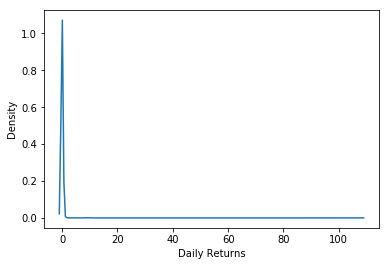

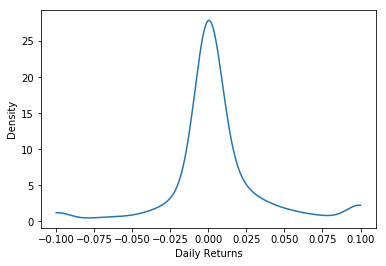

In [13]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()
    
test = frames['20040108']
density_plot(test['DlyReturn'])
test['DlyReturn'] = wins(test['DlyReturn'],-0.1,0.1)
density_plot(test['DlyReturn'])

In [14]:
def impute_specrisk(df):
    df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])
    return df

## Factor Exposures and Factor Returns
use the Ordinary Least Squares (OLS) method to estimate the factor exposures, $f_{j,t}$, by using $\beta_{i,j,t-2}$ as the independent variable, and $r_{i,t}$ as the dependent variable.

$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$  
where $i=1...N$ (N assets),   
and $j=1...k$ (k factors).

where $r_{i,t}$ is the return, $\beta_{i,j,t-2}$ is the factor exposure, and $f_{j,t}$ is the factor return.

In [15]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n):
    return list(filter(lambda x: "USFASTD_" in x, n))

def estimate_factor_returns(df): 
    ## build universe based on filters 
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
  
    ## winsorize returns for fitting 
    estu['DlyReturn'] = wins(estu['DlyReturn'], -0.25, 0.25)
  
    all_factors = factors_from_names(list(df))
    form = get_formula(all_factors, "DlyReturn")
    model = ols(form, data=estu)
    results = model.fit()
    return results

In [16]:
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date]).params

In [17]:
facret['20041230']

USFASTD_1DREVRSL    0.000611
USFASTD_AERODEF     0.002680
                      ...   
USFASTD_VALUE       0.001045
USFASTD_WIRELESS    0.007518
Length: 81, dtype: float64

In [18]:
# Backtest date list in Timestamp format
test_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))
test_dates

[Timestamp('2004-01-06 00:00:00'),
 Timestamp('2004-01-07 00:00:00'),
 Timestamp('2004-01-08 00:00:00'),
 Timestamp('2004-01-09 00:00:00'),
 Timestamp('2004-01-12 00:00:00'),
 Timestamp('2004-01-13 00:00:00'),
 Timestamp('2004-01-14 00:00:00'),
 Timestamp('2004-01-15 00:00:00'),
 Timestamp('2004-01-16 00:00:00'),
 Timestamp('2004-01-20 00:00:00'),
 Timestamp('2004-01-21 00:00:00'),
 Timestamp('2004-01-22 00:00:00'),
 Timestamp('2004-01-23 00:00:00'),
 Timestamp('2004-01-26 00:00:00'),
 Timestamp('2004-01-27 00:00:00'),
 Timestamp('2004-01-28 00:00:00'),
 Timestamp('2004-01-29 00:00:00'),
 Timestamp('2004-01-30 00:00:00'),
 Timestamp('2004-02-02 00:00:00'),
 Timestamp('2004-02-03 00:00:00'),
 Timestamp('2004-02-04 00:00:00'),
 Timestamp('2004-02-05 00:00:00'),
 Timestamp('2004-02-06 00:00:00'),
 Timestamp('2004-02-09 00:00:00'),
 Timestamp('2004-02-10 00:00:00'),
 Timestamp('2004-02-11 00:00:00'),
 Timestamp('2004-02-12 00:00:00'),
 Timestamp('2004-02-13 00:00:00'),
 Timestamp('2004-02-

## Alpha Factors

Use these factors as alpha factors from Barra's factors

* **USFASTD_1DREVRSL** : Reversal

* **USFASTD_EARNYILD** : Earnings Yield

* **USFASTD_VALUE** : Value

* **USFASTD_SENTMT** : Sentiment


/Users/yuki/miniconda3/envs/ai-alpha/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


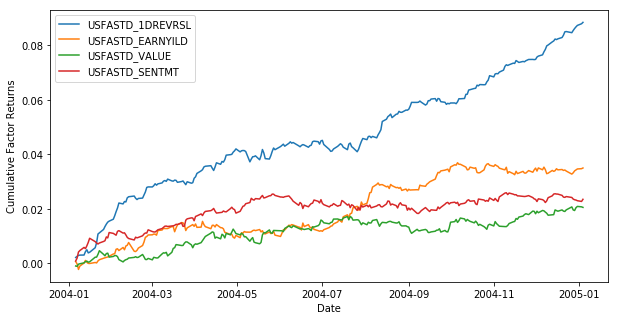

In [19]:
alpha_factors = ["USFASTD_1DREVRSL", "USFASTD_EARNYILD", "USFASTD_VALUE", "USFASTD_SENTMT"]
facret_df = pd.DataFrame(index = test_dates)
plt.figure(figsize=(10,5))
for dt in test_dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

for column in facret_df.columns:
        plt.plot(facret_df[column].cumsum(), label=column)

plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

In [20]:
def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

previous_holdings = pd.DataFrame(data = {"Barrid" : ["USA02P1"], "h.opt.previous" : np.array(0)})
df = frames[test_dates[0].strftime('%Y%m%d')]

df = df.merge(previous_holdings, how = 'left', on = 'Barrid')
df = clean_nas(df)
df = impute_specrisk(df)
df.head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,...,DataDate,DlyReturn,DlyReturnDate,h.opt.previous
0,USA0001,-0.032,0.000,0.0,...,20040102,0.0,20040106,0.0
1,USA0011,-0.059,0.000,0.0,...,20040102,0.0,20040106,0.0
...,...,...,...,...,...,...,...,...,...
3,USA0062,-0.128,0.431,0.0,...,20040102,0.0,20040106,0.0
4,USA00E2,0.374,0.000,0.0,...,20040102,0.0,20040106,0.0


Construct the universe of stocks as only those companies
 - that have a market capitalization of at least 1 billion dollars OR
 - that are in the previous day's holdings, even if on the current day, the company no longer meets the 1 billion dollar criteria.
 

In [21]:
def get_universe(df):
    universe = df.loc[(df['IssuerMarketCap'] >= 1e9) | (abs(df['h.opt.previous']) > 0.0)].copy()
    universe = universe.drop(['DlyReturn'], axis=1)
    
    return universe

universe = get_universe(df)
print(universe.shape)
universe.head()

(2265, 94)


,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,...,PredBeta,DataDate,DlyReturnDate,h.opt.previous
0,USA0001,-0.032,0.000,0.0,...,0.156387,20040102,20040106,0.0
1,USA0011,-0.059,0.000,0.0,...,0.147900,20040102,20040106,0.0
...,...,...,...,...,...,...,...,...,...
3,USA0062,-0.128,0.431,0.0,...,0.355564,20040102,20040106,0.0
4,USA00E2,0.374,0.000,0.0,...,0.412602,20040102,20040106,0.0


In [22]:
date = str(int(universe['DataDate'][0])) 
date

'20040102'

Define all the factors not used as alpha factors Risk factors

In [23]:
all_factors = factors_from_names(list(universe))
print(len(all_factors))
print(all_factors)

81
['USFASTD_1DREVRSL', 'USFASTD_AERODEF', 'USFASTD_AIRLINES', 'USFASTD_ALUMSTEL', 'USFASTD_APPAREL', 'USFASTD_AUTO', 'USFASTD_BANKS', 'USFASTD_BETA', 'USFASTD_BEVTOB', 'USFASTD_BIOLIFE', 'USFASTD_BLDGPROD', 'USFASTD_CHEM', 'USFASTD_CNSTENG', 'USFASTD_CNSTMACH', 'USFASTD_CNSTMATL', 'USFASTD_COMMEQP', 'USFASTD_COMPELEC', 'USFASTD_COMSVCS', 'USFASTD_CONGLOM', 'USFASTD_CONTAINR', 'USFASTD_DISTRIB', 'USFASTD_DIVFIN', 'USFASTD_DIVYILD', 'USFASTD_DWNRISK', 'USFASTD_EARNQLTY', 'USFASTD_EARNYILD', 'USFASTD_ELECEQP', 'USFASTD_ELECUTIL', 'USFASTD_FOODPROD', 'USFASTD_FOODRET', 'USFASTD_GASUTIL', 'USFASTD_GROWTH', 'USFASTD_HLTHEQP', 'USFASTD_HLTHSVCS', 'USFASTD_HOMEBLDG', 'USFASTD_HOUSEDUR', 'USFASTD_INDMACH', 'USFASTD_INDMOM', 'USFASTD_INSURNCE', 'USFASTD_INTERNET', 'USFASTD_LEISPROD', 'USFASTD_LEISSVCS', 'USFASTD_LEVERAGE', 'USFASTD_LIFEINS', 'USFASTD_LIQUIDTY', 'USFASTD_LTREVRSL', 'USFASTD_MEDIA', 'USFASTD_MGDHLTH', 'USFASTD_MGMTQLTY', 'USFASTD_MIDCAP', 'USFASTD_MOMENTUM', 'USFASTD_MULTUTIL', '

In [24]:
def setdiff(temp1, temp2): 
    s = set(temp2)
    temp3 = [x for x in temp1 if x not in s]
    return temp3

risk_factors = setdiff(all_factors, alpha_factors)
print(len(risk_factors))
print(risk_factors)

77
['USFASTD_AERODEF', 'USFASTD_AIRLINES', 'USFASTD_ALUMSTEL', 'USFASTD_APPAREL', 'USFASTD_AUTO', 'USFASTD_BANKS', 'USFASTD_BETA', 'USFASTD_BEVTOB', 'USFASTD_BIOLIFE', 'USFASTD_BLDGPROD', 'USFASTD_CHEM', 'USFASTD_CNSTENG', 'USFASTD_CNSTMACH', 'USFASTD_CNSTMATL', 'USFASTD_COMMEQP', 'USFASTD_COMPELEC', 'USFASTD_COMSVCS', 'USFASTD_CONGLOM', 'USFASTD_CONTAINR', 'USFASTD_DISTRIB', 'USFASTD_DIVFIN', 'USFASTD_DIVYILD', 'USFASTD_DWNRISK', 'USFASTD_EARNQLTY', 'USFASTD_ELECEQP', 'USFASTD_ELECUTIL', 'USFASTD_FOODPROD', 'USFASTD_FOODRET', 'USFASTD_GASUTIL', 'USFASTD_GROWTH', 'USFASTD_HLTHEQP', 'USFASTD_HLTHSVCS', 'USFASTD_HOMEBLDG', 'USFASTD_HOUSEDUR', 'USFASTD_INDMACH', 'USFASTD_INDMOM', 'USFASTD_INSURNCE', 'USFASTD_INTERNET', 'USFASTD_LEISPROD', 'USFASTD_LEISSVCS', 'USFASTD_LEVERAGE', 'USFASTD_LIFEINS', 'USFASTD_LIQUIDTY', 'USFASTD_LTREVRSL', 'USFASTD_MEDIA', 'USFASTD_MGDHLTH', 'USFASTD_MGMTQLTY', 'USFASTD_MIDCAP', 'USFASTD_MOMENTUM', 'USFASTD_MULTUTIL', 'USFASTD_OILGSCON', 'USFASTD_OILGSDRL', '

In [25]:
h0 = universe['h.opt.previous']
h0

0        0.0
1        0.0
        ... 
12391    0.0
12422    0.0
Name: h.opt.previous, Length: 2265, dtype: float64

## Risk Factor Exposures

In [26]:
formula = get_formula(risk_factors, "SpecRisk")
formula

'SpecRisk ~ 0 + USFASTD_AERODEF + USFASTD_AIRLINES + USFASTD_ALUMSTEL + USFASTD_APPAREL + USFASTD_AUTO + USFASTD_BANKS + USFASTD_BETA + USFASTD_BEVTOB + USFASTD_BIOLIFE + USFASTD_BLDGPROD + USFASTD_CHEM + USFASTD_CNSTENG + USFASTD_CNSTMACH + USFASTD_CNSTMATL + USFASTD_COMMEQP + USFASTD_COMPELEC + USFASTD_COMSVCS + USFASTD_CONGLOM + USFASTD_CONTAINR + USFASTD_DISTRIB + USFASTD_DIVFIN + USFASTD_DIVYILD + USFASTD_DWNRISK + USFASTD_EARNQLTY + USFASTD_ELECEQP + USFASTD_ELECUTIL + USFASTD_FOODPROD + USFASTD_FOODRET + USFASTD_GASUTIL + USFASTD_GROWTH + USFASTD_HLTHEQP + USFASTD_HLTHSVCS + USFASTD_HOMEBLDG + USFASTD_HOUSEDUR + USFASTD_INDMACH + USFASTD_INDMOM + USFASTD_INSURNCE + USFASTD_INTERNET + USFASTD_LEISPROD + USFASTD_LEISSVCS + USFASTD_LEVERAGE + USFASTD_LIFEINS + USFASTD_LIQUIDTY + USFASTD_LTREVRSL + USFASTD_MEDIA + USFASTD_MGDHLTH + USFASTD_MGMTQLTY + USFASTD_MIDCAP + USFASTD_MOMENTUM + USFASTD_MULTUTIL + USFASTD_OILGSCON + USFASTD_OILGSDRL + USFASTD_OILGSEQP + USFASTD_OILGSEXP + USF

In [27]:
def get_B(factors, universe):
    formula = get_formula(factors, "SpecRisk")
    outcome, predictors = patsy.dmatrices(formula, universe)
    return predictors

B = get_B(risk_factors, universe)
BT = B.transpose()

print(B.shape)
print(np.asarray(B))
B

(2265, 77)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


DesignMatrix with shape (2265, 77)
  Columns:
    ['USFASTD_AERODEF',
     'USFASTD_AIRLINES',
     'USFASTD_ALUMSTEL',
     'USFASTD_APPAREL',
     'USFASTD_AUTO',
     'USFASTD_BANKS',
     'USFASTD_BETA',
     'USFASTD_BEVTOB',
     'USFASTD_BIOLIFE',
     'USFASTD_BLDGPROD',
     'USFASTD_CHEM',
     'USFASTD_CNSTENG',
     'USFASTD_CNSTMACH',
     'USFASTD_CNSTMATL',
     'USFASTD_COMMEQP',
     'USFASTD_COMPELEC',
     'USFASTD_COMSVCS',
     'USFASTD_CONGLOM',
     'USFASTD_CONTAINR',
     'USFASTD_DISTRIB',
     'USFASTD_DIVFIN',
     'USFASTD_DIVYILD',
     'USFASTD_DWNRISK',
     'USFASTD_EARNQLTY',
     'USFASTD_ELECEQP',
     'USFASTD_ELECUTIL',
     'USFASTD_FOODPROD',
     'USFASTD_FOODRET',
     'USFASTD_GASUTIL',
     'USFASTD_GROWTH',
     'USFASTD_HLTHEQP',
     'USFASTD_HLTHSVCS',
     'USFASTD_HOMEBLDG',
     'USFASTD_HOUSEDUR',
     'USFASTD_INDMACH',
     'USFASTD_INDMOM',
     'USFASTD_INSURNCE',
     'USFASTD_INTERNET',
     'USFASTD_LEISPROD',
     'USFASTD_LEI

## Specific Variance

In [28]:
universe['SpecRisk'][0:2]

0     9.014505
1    11.726327
Name: SpecRisk, dtype: float64

In [29]:
# Specific Risk are in percentage, so re-scale to decimals and square
specVar = (0.01 * universe['SpecRisk']) ** 2
specVar[0:2]

0    0.008126
1    0.013751
Name: SpecRisk, dtype: float64

## Factor Covariance

In [30]:
covariance[date].head()

,Factor1,Factor2,VarCovar,DataDate
0,USFASTD_1DREVRSL,USFASTD_1DREVRSL,1.958869,20040102
1,USFASTD_1DREVRSL,USFASTD_BETA,1.602458,20040102
...,...,...,...,...
3,USFASTD_1DREVRSL,USFASTD_DWNRISK,-0.064387,20040102
4,USFASTD_1DREVRSL,USFASTD_EARNQLTY,0.046573,20040102


When filling the risk factor matrix, we can use just the variances and set the covariances in the off-diagonals to zero.

In [31]:
def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_cov_element(cv, factor1, factor2): 
    try:
        return(cv.loc[(cv.Factor1==factor1) & (cv.Factor2==factor2),"VarCovar"].iloc[0])
    except:
        return 0 


def factor_cov(date, B):  
    cv = covariance[date]
    k = np.shape(B)[1]
    Fm = np.zeros([k,k])
    for i in range(0,k):
        j=i
        fac1 = colnames(B)[i]
        fac2 = colnames(B)[j]
        # Convert from percentage units squared to decimal
        Fm[i,j] = (0.01**2) * get_cov_element(cv, fac1, fac2)
    return(Fm)


def get_F(date, B):
    """
    Create the factor variance matrix

    Parameters
    ----------
    date : string
           date. For example 20040102

    B : patsy.design_info.DesignMatrix OR pandas.core.frame.DataFrame
        Matrix of Risk Factors

    Returns
    -------
    Fm : Numpy ndarray
        factor covariance matrix
    """

    return np.diag(np.diag(factor_cov(date, B)))

Fvar = get_F(date, B)
print(Fvar.shape)
Fvar

(77, 77)


array([[0.00845121, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04305446, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02307853, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00521378, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00726435,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02185539]])

In [32]:
def diagonal_factor_cov(date, B):
    """
    Create the factor covariance matrix

    Parameters
    ----------
    date : string
           date. For example 20040102
    B : patsy.design_info.DesignMatrix OR pandas.core.frame.DataFrame
        Matrix of Risk Factors
        
    Returns
    -------
    Fm : Numpy ndarray
        factor covariance matrix
    """
    
    factor_names = colnames(B)
    k = len(factor_names)
    Fm = np.zeros([k, k])
    num_found = 0 
    num_not_found = 0
    
    for i in range(0, k):
        factor1 = factor_names[i]
        for j in range(0, k):
            factor2 = factor_names[j]
            try:
                cov12 = covariance[date].loc[(covariance[date]['Factor1'] == factor1) & (covariance[date]['Factor2'] == factor2), 'VarCovar'].iloc[0]
                # print(f"found covariance for: factor 1: {factor1} factor2: {factor2}")
                num_found += 1
            except:
                # print(f"didn't find covariance for: factor 1: {factor1} factor2: {factor2}")
                num_not_found += 1
                cov12 = 0
            Fm[i, j] = cov12 * (0.01**2)    
    # print(f'Found: {num_found}, Not Found: {num_not_found}')
    return Fm

Fcov = diagonal_factor_cov(date, B)
Fcov

array([[ 0.00845121,  0.00032519,  0.        , ...,  0.00020492,
         0.00044973, -0.00038478],
       [ 0.        ,  0.04305446,  0.        , ...,  0.        ,
         0.00415129,  0.00080648],
       [ 0.00120044,  0.00226295,  0.02307853, ...,  0.00237209,
         0.00112863, -0.00027942],
       ...,
       [ 0.        ,  0.0017087 ,  0.        , ...,  0.00521378,
         0.00063814, -0.00072428],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00726435, -0.0001058 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.02185539]])

## Transaction Cost

Explicit cost such as commissions are far smaller than market impact.
Define the transaction cost, or slippage, as to multiply the price change due to market impact by the amount of dollars traded.

Here, use linear impact model because the slope is not available in public.
Good estimate according the past researches is, each 1% of Average Daily Volume Traded moves the price by 10 basis point.

$$
\mbox{tcost}_{i,t} = \% \Delta \mbox{price}_{i,t} \times \mbox{trade}_{i,t} = (0.1 \times (h_{i,t} - h_{i,t-1}) \div \mbox{ADV}_{i,t}) \times (h_{i,t} - h_{i,t-1})
$$

that is,
$$
\mbox{tcost}_{i,t} = \sum_i^{N} \lambda_{i,t} (h_{i,t} - h_{i,t-1})^2
$$  
where
$$
\lambda_{i,t} = \frac{1}{10\times \mbox{ADV}_{i,t}}
$$

When ADV is missing or zero, consider it to be a small number like 10,000 and highly illiquid.


In [33]:
def get_lambda(universe, composite_volume_column = 'ADTCA_30'):
    universe.loc[np.isnan(universe[composite_volume_column]), composite_volume_column] = 1.0e4
    universe.loc[universe[composite_volume_column] == 0, composite_volume_column] = 1.0e4 

    adv = universe[composite_volume_column]
    
    return 0.1 / adv

Lambda = get_lambda(universe)
Lambda

0        1.000000e-05
1        1.000000e-05
             ...     
12391    8.186089e-09
12422    7.648435e-08
Name: ADTCA_30, Length: 2265, dtype: float64

## Alpha Factor Exposure
Factor exposures is in % change and assume 1 unit of factor exposure maps to 1 basis point of daily return because:
 -  1bps annualized = 1.0001**252 --> 2.55%
 - -1bps annualized = 9.9999**252 --> -2.49%
That is, annualized spread of a +1bps and -1bps returns stock is 504bps, or a bout 5%.

In [34]:
B_alpha = get_B(alpha_factors, universe)
B_alpha

DesignMatrix with shape (2265, 4)
  USFASTD_1DREVRSL  USFASTD_EARNYILD  USFASTD_VALUE  USFASTD_SENTMT
            -0.032            -0.298          0.644          -0.922
            -0.059            -1.072         -0.646          -0.991
             0.457            -0.060         -0.668          -0.092
            -0.128            -0.681          0.028          -0.772
             0.374             0.392         -0.735           0.489
            -0.254             0.185          0.188           0.033
            -0.317             0.748          2.049           0.628
             0.157            -0.438         -0.449           0.631
            -0.550            -0.691         -0.645           0.225
            -0.169             0.038         -1.002           0.053
            -1.019            -0.946         -0.588           1.371
             0.334            -0.197         -0.465          -0.287
             0.490             0.036         -0.370          -0.685
            -0

In [35]:
def get_alpha_vec(B_alpha):
    '''Returns Alpha Vector'''
    scale = 1e-4    
    
    return scale * np.sum(B_alpha, axis=1)

alpha_vec = get_alpha_vec(B_alpha)
alpha_vec

array([-6.080e-05, -2.768e-04, -3.630e-05, ...,  1.900e-06,  1.679e-04,
        3.930e-05])

## Objective Function

The objective function to minimize is (factor risk (Risk aversion * Common Risk) + idiosyncratic risk (Risk Aversion * Specific Risk) - expected portfolio return + transaction costs):

$
f(\mathbf{h}) = \frac{1}{2}\kappa \mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t + \frac{1}{2} \kappa \mathbf{h}_t^T \mathbf{S} \mathbf{h}_t - \mathbf{\alpha}^T \mathbf{h}_t + (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda} (\mathbf{h}_{t} - \mathbf{h}_{t-1})
$
 
where $\kappa$ is risk aversion factor, applied to any size metrics. (e.g. $GMV = \sum_i^{N}(|\mathbf{h}_i|)$ is a L1-norm)


$
Common\textbf{ }Risk = \frac{1}{2} \mathbf{h}_t^T\textbf{BFB}^T\mathbf{h}_t
$


where, $\textbf{B}$ is the risk factor exposures, $\textbf{F}$ is the risk factor variance and $\textbf{h}_t$ is the portfolio's holdings at time $t$.


$\textbf{B}$ is $N$ by $K$ matrix, $\textbf{F}$ is $K$ by $K$ matrix and $\textbf{B}^T$ is $K$ by $N$ matrix, resulting in $\textbf{BFB}^T$ as a huge $N \times N$ matrix (e.g. 2,000 assets $\times$ 2,000 assets = 2 million)

To avoid this, covert it to $\textbf{Q}^T\textbf{Q}$, by the following:



$\textbf{BFB}^T$ = $\textbf{BGGB}^T$ = $\textbf{Q}^T\textbf{Q}$, where $\textbf{Q} = \textbf{GB}^T$. Then the resulting $\textbf{Qh} = \textbf{R}$, $\textbf{Q}^T\textbf{h}^T = \textbf{R}^T$ are just $K$ by 1 vector and 1 by $K$ vector, respectively. Then,

$
Common\textbf{ }Risk = \frac{1}{2}\mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t 
$


This model include aspects of Market neutral, Position Size, Portfolio Diversification without using Constraints, which is high in computational cost.

In [36]:
risk_aversion = 1.0e-6

def get_Q(Fvar, BT):
    return np.matmul(scipy.linalg.sqrtm(Fvar), BT)

Q = get_Q(Fvar, BT)
QT = Q.transpose()

def get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda): 
    def obj_func(h):
        f = 0.0
        f += 0.5 * risk_aversion * np.sum(np.matmul(Q, h)**2)
        f += 0.5 * risk_aversion * np.dot(h**2, specVar)
        f -= np.dot(h, alpha_vec)
        f += np.dot((h - h0)**2, Lambda)        
        return f
    
    return obj_func

## Gradient
The gradient, or derivative of the objective function, with respect to the portfolio holdings h, is given by:  

$$
f'(\mathbf{h}) = \frac{1}{2}\kappa (2\mathbf{Q}^T\mathbf{Qh}) + \frac{1}{2}\kappa (2\mathbf{Sh}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}
$$

In [37]:
def get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda):
    def grad_func(h):
        result = risk_aversion * (np.matmul(QT, np.matmul(Q,h)) + (specVar * h) ) - alpha_vec + 2 * (h-h0) * Lambda
        return (np.asarray(result))
    
    return grad_func

## Optimize

In [38]:
def get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda):
    """
    Optimize the objective function

    Parameters
    ----------        
    risk_aversion : int or float 
        Trader's risk aversion
        
    Q : patsy.design_info.DesignMatrix 
        Q Matrix
        
    QT : patsy.design_info.DesignMatrix 
        Transpose of the Q Matrix
        
    specVar: Pandas Series 
        Specific Variance
        
    alpha_vec: patsy.design_info.DesignMatrix 
        alpha vector
        
    h0 : Pandas Series  
        initial holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    optimizer_result[0]: Numpy ndarray 
        optimized holdings
    """
    obj_func = get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda)
    grad_func = get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda)
    
    optimizer_result = scipy.optimize.fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    h1 = optimizer_result[0]
    
    return h1

h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)
print(len(h_star))
h_star

2265


array([ -4.12382319, -22.2392698 ,   1.49472868, ..., 766.23935786,
       511.48881572, 529.06617741])

In [39]:
opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})
opt_portfolio

,Barrid,h.opt
0,USA0001,-4.123823
1,USA0011,-22.239270
...,...,...
12391,USAZXI1,511.488816
12422,USAZZ81,529.066177


## Risk Exposures
$$
Risk \mbox{ } Exposures = \textbf{B}_{risk}^T h_{t}
$$

In [40]:
def get_port_risk_exposures(B, BT, h_star):
    """
    Calculate portfolio's Risk Exposure

    Parameters
    ----------
    B : patsy.design_info.DesignMatrix 
        Matrix of Risk Factors
        
    BT : patsy.design_info.DesignMatrix 
        Transpose of Matrix of Risk Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    risk_exposures : Pandas Series
        Risk Exposures
    """
    return pd.Series(np.matmul(BT, h_star), index=colnames(B))

portfolio_risk_exposures = get_port_risk_exposures(B, BT, h_star)
portfolio_risk_exposures

USFASTD_AERODEF    -4085.335469
USFASTD_AIRLINES    -894.645270
                       ...     
USFASTD_TRANSPRT   -1376.885901
USFASTD_WIRELESS    4601.429421
Length: 77, dtype: float64

## Alpha Exposures
$$
Alpha \mbox{ } Exposures = \textbf{B}_{alpha}^T h_{t}
$$

In [41]:
def get_port_alpha_exposure(B_alpha, h_star):
    """
    Calculate portfolio's Alpha Exposure

    Parameters
    ----------
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    alpha_exposures : Pandas Series
        Alpha Exposures
    """
    return pd.Series(np.matmul(B_alpha.transpose(), h_star), index = colnames(B_alpha))

portfolio_alpha_exposure = get_port_alpha_exposure(B_alpha, h_star)
portfolio_alpha_exposure

USFASTD_1DREVRSL    2.259360e+06
USFASTD_EARNYILD    1.753336e+06
USFASTD_VALUE       2.255301e+06
USFASTD_SENTMT      1.271304e+06
dtype: float64

## Transaction Cost
Total transaction costs:
$$
Transaction \mbox{ } Cost = \sum_i^{N} \lambda_{i} (h_{i,t} - h_{i,t-1})^2
$$

In [42]:
def get_total_transaction_costs(h0, h_star, Lambda):
    """
    Calculate Total Transaction Costs

    Parameters
    ----------
    h0 : Pandas Series
        initial holdings (before optimization)
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    total_transaction_costs : float
        Total Transaction Costs
    """
    return np.sum(np.dot((h_star - h0)**2, Lambda))

total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
total_transaction_costs

104.87985013279145

## Pipeline

In [43]:
def form_optimal_portfolio(df, previous, risk_aversion):
    '''Returns the optimal portfolio, risk and alpha exposures and the total transaction cost'''
    df = df.merge(previous, how = 'left', on = 'Barrid')
    df = clean_nas(df)
    df = impute_specrisk(df)
  
    universe = get_universe(df)
    date = str(int(universe['DataDate'][1]))
  
    h0 = universe['h.opt.previous']
  
    B = get_B(risk_factors, universe)
    BT = B.transpose()
  
    specVar = (0.01 * universe['SpecRisk']) ** 2
    Fvar = get_F(date, B)
    
    B_alpha = get_B(alpha_factors, universe)
    alpha_vec = get_alpha_vec(B_alpha)

    Lambda = get_lambda(universe)

    Q = get_Q(Fvar, BT)
    QT = Q.transpose()
    
    h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)
    opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})
    
    portfolio_risk_exposures = get_port_risk_exposures(B, BT, h_star)
    portfolio_alpha_exposure = get_port_alpha_exposure(B_alpha, h_star)
    total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
  
    return {
        "opt.portfolio" : opt_portfolio, 
        "risk.exposures" : portfolio_risk_exposures, 
        "alpha.exposures" : portfolio_alpha_exposure,
        "total.cost" : total_transaction_costs}

def build_tradelist(prev_holdings, opt_result):
    '''Returns the trades on the day'''
    tmp = prev_holdings.merge(opt_result['opt.portfolio'], how='outer', on = 'Barrid')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

def convert_to_previous(result): 
    '''Save optimal holdings as previous optimal holdings'''
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev

## Run the backtest
Walk through each day, calculating the optimal portfolio holdings and trade list.

In [44]:
trades = {}
port = {}

for dt in tqdm(test_dates, desc='Optimizing Portfolio', unit='day'):
    date = dt.strftime('%Y%m%d')

    result = form_optimal_portfolio(frames[date], previous_holdings, risk_aversion)
    trades[date] = build_tradelist(previous_holdings, result)
    port[date] = result
    previous_holdings = convert_to_previous(result)

Optimizing Portfolio: 100%|██████████| 252/252 [14:27<00:00,  3.44s/day]


## PnL Attribution
Profit and Loss is the aggregate realized daily returns of the assets, weighted by the optimal portfolio holdings chosen, and summed up to get the portfolio's profit and loss.

The PnL attributed to the alpha factors equals the factor returns times factor exposures for the alpha factors.  

$$
\mbox{PnL}_{alpha}= f \times b_{alpha}
$$

Similarly, the PnL attributed to the risk factors equals the factor returns times factor exposures of the risk factors.

$$
\mbox{PnL}_{risk} = f \times b_{risk}
$$

In [47]:
def partial_dot_product(v, w):
    '''Return sum of two Pandas Series for common indices.'''
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 
    
    df = pd.DataFrame(index = test_dates)
    
    for dt in test_dates:
        date = dt.strftime('%Y%m%d')

        p = port[date]
        fr = facret[date]

        mf = p['opt.portfolio'].merge(frames[date], how = 'left', on = "Barrid")
        
        mf['DlyReturn'] = wins(mf['DlyReturn'], -0.5, 0.5)
        df.at[dt,"daily.pnl"] = np.sum(mf['h.opt'] * mf['DlyReturn'])
        df.at[dt,"attribution.alpha.pnl"] = partial_dot_product(fr, p['alpha.exposures'])
        df.at[dt,"attribution.risk.pnl"] = partial_dot_product(fr, p['risk.exposures']) 
        df.at[dt,"attribution.cost"] = p['total.cost'] * -1
        
    return df 

attr = build_pnl_attribution()
attr

,daily.pnl,attribution.alpha.pnl,attribution.risk.pnl,attribution.cost
2004-01-06,3174.324201,4833.757921,917.161320,-104.879850
2004-01-07,-1732.002038,379.321518,606.221940,-64.709849
...,...,...,...,...
2005-01-03,2791.035021,392.689931,-292.646378,-67.863961
2005-01-04,6460.645612,4157.621777,187.853181,-82.269614


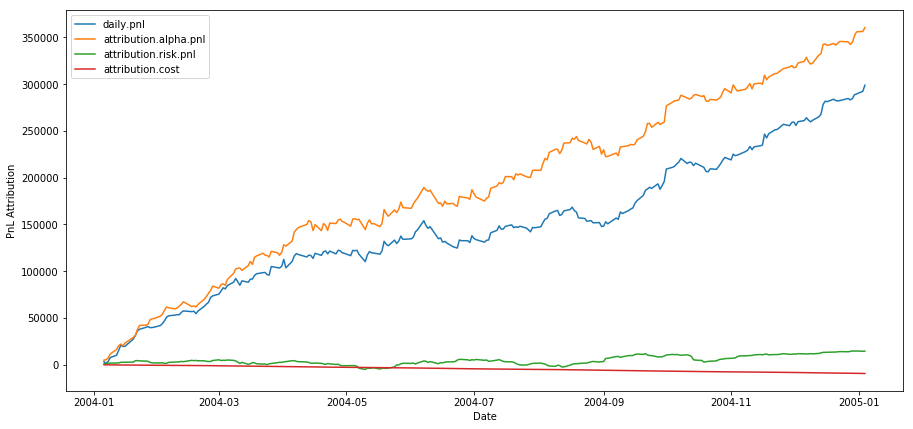

In [48]:
# Plot
plt.figure(figsize=(15,7))
for column in attr.columns:
        plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

## Build portfolio characteristics
Calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.

In [50]:
def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = test_dates)
    
    for dt in test_dates:
        date = dt.strftime('%Y%m%d')
  
        p = port[date]
        tradelist = trades[date]
        h = p['opt.portfolio']['h.opt']
        
        df.at[dt,"long"] = np.sum(h[h>0])
        df.at[dt,"short"] = np.sum(h[h<0])
        df.at[dt,"net"] = np.sum(h)
        df.at[dt,"gmv"] = np.sum(np.abs(h))
        df.at[dt,"traded"] = np.sum(abs(tradelist['h.opt'] - tradelist['h.opt.previous']))
        
    return df

pchar = build_portfolio_characteristics()
pchar

,long,short,net,gmv,traded
2004-01-06,1.963969e+06,-1.964191e+06,-222.102095,3.928160e+06,3.928160e+06
2004-01-07,2.243385e+06,-2.228708e+06,14677.256490,4.472092e+06,3.115569e+06
...,...,...,...,...,...
2005-01-03,3.981829e+06,-3.974177e+06,7651.463971,7.956006e+06,3.755669e+06
2005-01-04,4.336192e+06,-4.298752e+06,37439.836894,8.634945e+06,4.069164e+06


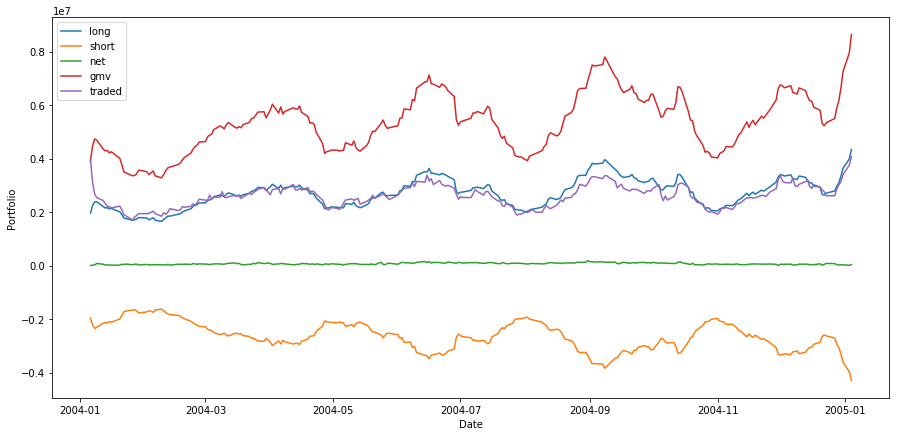

In [51]:
# Plot
plt.figure(figsize=(15,7))
for column in pchar.columns:
        plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()

## Further consideration...
This is just a view on how the alpha would perform. To do full backtest, need to consider the followings.
#### Extract sentiment
The idea is to use alternative data for alpha. To include sentiments from textual data, the data access is required. Twitter and Stockswit does not provide free access to get massive historial tweets. Financial news website also have limitations to download reasonable dataset by scraping. Financial Statement and Earnings Calls can be used but they are less frequent.

#### Market data and factors
The latest stock price data can be accessed via providers like Quandle but the use is limited. Realistically commercial factor data should be used for backtest but such data are not available for personal use at a reasonable cost. Furthermore, asset pricing other than stocks such as bonds are not always available - only EOD price for government bonds is accessible.

#### Comutational resource
The dataset is large (~TB). Running optimizations including machine learning on daily basis for hundreds of days are very expensitve and time consuming. Need to consider how to split workers to have parallel processing.